# FGSM attack on a basic CNN
This is an example of **fast gradient sign method** applied on MNIST dataset and refers to the model `src/baseline_convnet.py` 

In [1]:
import sys
from os.path import abspath

sys.path.append(abspath('../src/'))

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from utils import *
from baseline_convnet import BaselineConvnet
import matplotlib.pyplot as plt
from sklearn import preprocessing
import random

Using TensorFlow backend.


In [2]:
x_train, y_train, x_test, y_test, input_shape, num_classes = preprocess_mnist()
model = BaselineConvnet(input_shape=input_shape, num_classes=num_classes)
classifier = model.load_classifier("IBM-art/mnist_cnn_original.h5")


Loading mnist.
x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Accuracy of the trained model

In [3]:
x_test_pred = model.evaluate_test(classifier, x_test, y_test)


Testing infos:
x_test.shape =  (10000, 28, 28, 1) 
y_test.shape =  (10000, 10) 


Original test data.
Correctly classified: 9923
Incorrectly classified: 77
Test accuracy: 99.23%


### Testing the model on adversaries

In [4]:
x_test_fgsm, x_test_fgsm_pred = model.evaluate_adversaries(classifier, x_test, y_test)


Adversarial evaluation using FGSM method.

Adversarial test data.
Correctly classified: 2417
Incorrectly classified: 7583
Adversarial accuracy: 24.17%


In [5]:
x_test_deepfool, x_test_deepfool_pred = model.evaluate_adversaries(classifier, x_test, y_test, method='deepfool',
                                        adversaries_path='../data/mnist_x_test_deepfool.pkl')


Adversarial test data.
Correctly classified: 572
Incorrectly classified: 9428
Adversarial accuracy: 5.72%


In [6]:
x_test_carlini, x_test_carlini_pred = model.evaluate_adversaries(classifier, x_test, y_test, 
                                                           method='carlini_l2', 
                                                           adversaries_path='../data/mnist_x_test_carlini.pkl')


Adversarial test data.
Correctly classified: 10000
Incorrectly classified: 0
Adversarial accuracy: 100.00%


In [7]:
x_test_virtual, x_test_virtual_pred = model.evaluate_adversaries(classifier, x_test, y_test, 
                                                           method='virtual_adversarial', 
                                                           adversaries_path='../data/mnist_x_test_virtual.pkl')


Adversarial test data.
Correctly classified: 9803
Incorrectly classified: 197
Adversarial accuracy: 98.03%


## A look at the adversaries

### FGSM adversaries
Now we show some examples of correct predictions on the test set and wrong predictions on the adversarially generated test set

test prediction		 adversarial test prediction
4 			 6
4 			 7
5 			 3
5 			 8
4 			 8


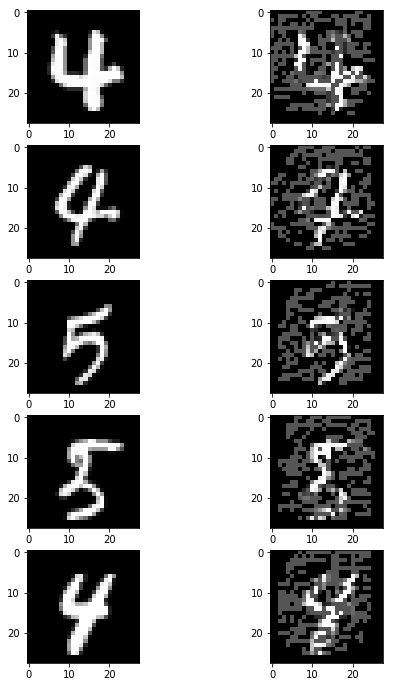

In [8]:
# one hot decoding of the labels
y_test_numeric = np.argmax(y_test, axis=1)

# idxs for correct predictions on test set, wrong on adversarial test set
idxs = np.where((y_test_numeric == x_test_pred) & (y_test_numeric != x_test_fgsm_pred))[0]

# reshape image arrays
im_test = [im.reshape(28, 28) for im in x_test]
im_test_fgsm = [im.reshape(28, 28) for im in x_test_fgsm]

# randomly sample n images
random.seed(111)
n = 5 
plot_idxs = np.random.choice(idxs, n)

f, ax = plt.subplots(n, 2, figsize=(8,12))
print("test prediction\t\t adversarial test prediction")
for i,idx in enumerate(plot_idxs):
    ax[i,0].imshow(im_test[idx], cmap='gray')
    ax[i,1].imshow(im_test_fgsm[idx], cmap='gray')
    print(x_test_pred[idx],"\t\t\t", x_test_fgsm_pred[idx])
plt.show()

	test  	fgsm  	deepfool  	carlini  	virtual


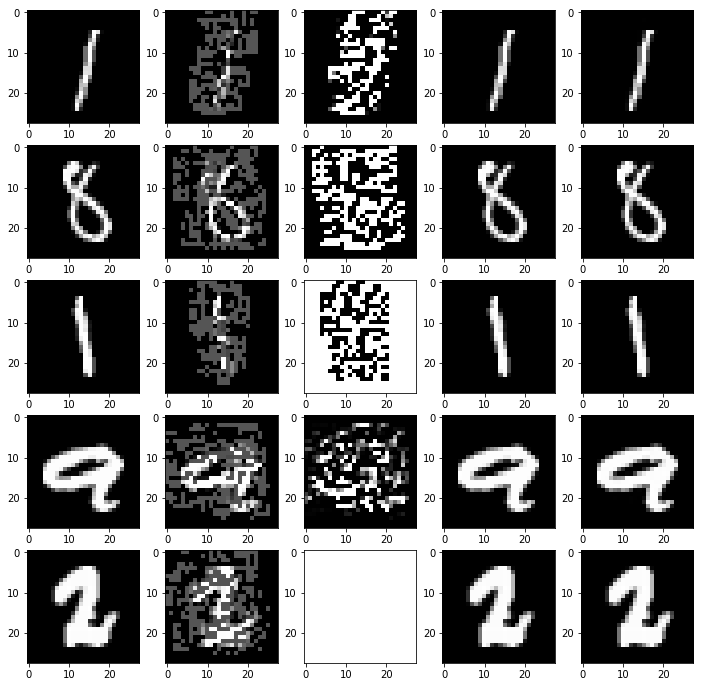

In [15]:
# one hot decoding of the labels
y_test_numeric = np.argmax(y_test, axis=1)

# idxs for correct predictions on test set, wrong on adversarial test set
#idxs = np.where((y_test_numeric == x_test_pred) & (y_test_numeric != x_test_adv_pred))[0]
x_test_pred = np.argmax(model.predict(classifier, x_test), axis=1)
x_test_adv_pred = np.argmax(model.predict(classifier, x_test_fgsm), axis=1)
idxs = np.where((y_test_numeric == x_test_pred) & (y_test_numeric != x_test_adv_pred))[0]

# reshape image arrays
im_test = [im.reshape(28, 28) for im in x_test]
im_test_fgsm = [im.reshape(28, 28) for im in x_test_fgsm]
im_test_deepfool = [im.reshape(28, 28) for im in x_test_deepfool]
im_test_carlini = [im.reshape(28, 28) for im in x_test_carlini]
im_test_virtual = [im.reshape(28, 28) for im in x_test_virtual]


# randomly sample n images
random.seed(111)
n = 5 
plot_idxs = np.random.choice(idxs, n)

f, ax = plt.subplots(n, 5, figsize=(12,12))
print("\ttest  \tfgsm  \tdeepfool  \tcarlini  \tvirtual")
for i,idx in enumerate(plot_idxs):
    ax[i,0].imshow(im_test[idx], cmap='gray')
    ax[i,1].imshow(im_test_fgsm[idx], cmap='gray')
    ax[i,2].imshow(im_test_deepfool[idx], cmap='gray')
    ax[i,3].imshow(im_test_carlini[idx], cmap='gray')
    ax[i,4].imshow(im_test_virtual[idx], cmap='gray')
    #print(x_test_pred[idx],"\t\t\t", x_test_adv_pred[idx])
plt.show()

## Adversarial training
Loading adversarially trained model. The attack used on this model is FGSM.

In [10]:
x_train, y_train, x_test, y_test, input_shape, num_classes = preprocess_mnist()
convNet = BaselineConvnet(input_shape=input_shape, num_classes=num_classes)
classifier = convNet.load_classifier("IBM-art/mnist_cnn_robust.h5")


Loading mnist.
x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)


Evaluating the adversarially FGSM trained baseline on the test set, also perturbed using FGSM, gives good accuracy.

In [11]:
x_test_fgsm, x_test_fgsm_pred = convNet.evaluate_adversaries(classifier, x_test, y_test, method='fgsm')


Adversarial evaluation using FGSM method.

Adversarial test data.
Correctly classified: 8145
Incorrectly classified: 1855
Adversarial accuracy: 81.45%


But if we evaluate the same model on test data perturbed using deepfool the results drop.

In [12]:
x_test_deepfool, x_test_deepfool_pred = convNet.evaluate_adversaries(classifier, x_test, y_test, 
                                                                     method='deepfool',
                                                                     adversaries_path='../data/mnist_x_test_deepfool.pkl')


Adversarial test data.
Correctly classified: 850
Incorrectly classified: 9150
Adversarial accuracy: 8.50%
